Merge test results, organized by dependent variable

- Input:
  - statistical_results/variable/*
  - 
- Output:
  - statistical_results/variable/joined/*
 
Run until postprocessing, with all variables and then postprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [2]:
SAVE_FIGS = False # change
SAVE_TABLES = False

In [29]:
# variables =['global_energy',
#                 "avg_cpu_usage_config",'avg_used_memory_pct_config',
#                 'avg_utilization_gpu_config','avg_utilization_memory_config','avg_used_memory_pct_mib',
#                 'avg_Load', 'duration'
#                 ]

variables =['global_energy',
                "avg_cpu_usage_config",'avg_used_memory_pct_config', 'duration'
                ]

cuda_variables =['avg_utilization_gpu_config','avg_utilization_memory_config','avg_used_memory_pct_mib']

#dependent_variable= cuda_variables[0] # change
dependent_variable= variables[-1] # change

print(f"dependent_variable: {dependent_variable}")

# D:/GAISSA/energy-repo/repo_sept_last_update/cudaep_nov_results/nov_cudaep_00/statistical_results_nov_nvidia/
#path = f"D:/GAISSA/energy-repo/last_repo/results_tests_02/{dependent_variable}"  # change results dir
#path = f"D:/GAISSA/energy-repo/last_repo/results_tests_02_nvidia/{dependent_variable}"  # change results dir

#general_path = f"D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_nvidia/" # change
#path = f"D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_nvidia/{dependent_variable}"  # change results dir

general_path = f"D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/" # change
path = f"D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/{dependent_variable}"  # change results dir

#general_path = f"D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cudaep_02/" # change
#path = f"D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cudaep_02/{dependent_variable}"  # change results dir

dependent_variable: duration


In [30]:
joined_dir = path+"/joined"
try:
    print("Directory created in: "+ joined_dir)
    os.mkdir( joined_dir)
except Exception as e:
    print("could not create directory "+ joined_dir)
    print(e)

Directory created in: D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/duration/joined
could not create directory D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/duration/joined
[WinError 183] Cannot create a file when that file already exists: 'D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/duration/joined'


## Normality

In [31]:
import os
import re

def merge_latex_tables(directory, output_file):
    # Regex to match the filename and extract the model
    filename_regex = re.compile(r'normality_(.+)_'+dependent_variable+'\.tex$')
    
    # Start of the new LaTeX table
    merged_table = [
        "\\begin{tabular}{lrrr}",
        "\\toprule",
        "model & config & W-statistic & p-value & significance \\\\",
        "\\midrule"
    ]
    
    # Process each file in the directory
    for file in os.listdir(directory):
        
        match = filename_regex.match(file)
        if match:
            print(f"file : {file}")
            model = match.group(1)  # Extract the model name
            path = os.path.join(directory, file)
            with open(path, 'r') as f:
                lines = f.readlines()
            
            # Find the beginning and the end of the tabular environment
            start = next(i for i, line in enumerate(lines) if '\\begin{tabular}' in line)
            end = next(i for i, line in enumerate(lines) if '\\end{tabular}' in line)
            
            # Process each line within the tabular environment to add the model name
            for line in lines[start + 4:end - 1]:  # skip the table header and footer of the individual files
                merged_table.append(model + ' & ' + line.strip())
    
    # End of the new LaTeX table
    merged_table += [
        "\\bottomrule",
        "\\end{tabular}"
    ]
    
    # Write the new LaTeX table to the output file
    if SAVE_TABLES:
        with open(output_file, 'w') as f:
            f.write('\n'.join(merged_table)) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
        print(f"Merged table written to {output_file}")
    else:
        print(f"NOT SAVED: Merged table written to {output_file}")
# Example usage
if __name__ == "__main__":
    directory = path  # Directory containing the files
    output_file = joined_dir+"/"+f'normality_{dependent_variable}_merged.tex'  # Name of the output LaTeX file
    merge_latex_tables(directory, output_file)


file : normality_bloomz-1b1_duration.tex
file : normality_bloomz-560m_duration.tex
file : normality_codegemma-2b_duration.tex
file : normality_codeparrot-small_duration.tex
file : normality_phi2_duration.tex
file : normality_pythia-410m_duration.tex
file : normality_pythia1-4b_duration.tex
file : normality_stablecode-3b-completion_duration.tex
file : normality_stablecode-3b_duration.tex
file : normality_starcoderbase-1b_duration.tex
file : normality_tiny-starcoder_duration.tex
file : normality_tinyllama_duration.tex
NOT SAVED: Merged table written to D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/duration/joined/normality_duration_merged.tex


## Levene

In [32]:
import os
import re

def extract_table_data(filepath):
    """ Extracts table data from a LaTeX file. """
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()
    # Extract the content between \begin{tabular} and \end{tabular}
    match = re.search(r'\\begin{tabular}{.*?}(.*?)\\end{tabular}', content, re.DOTALL)
    if match:
        # Extract only the rows between \midrule and \bottomrule
        mid_to_bottom = re.search(r'\\midrule(.*?)\\bottomrule', match.group(1), re.DOTALL)
        if mid_to_bottom:
            # Extract rows, remove any leading/trailing whitespace
            return [row.strip() for row in mid_to_bottom.group(1).split('\\\\') if row.strip()]
    return []

def merge_tables(directory, pattern):
    # List all .tex files matching the pattern
    files = [f for f in os.listdir(directory) if re.match(pattern, f)]
    
    # Start building the new table
    new_table_content = "\\begin{tabular}{llrr}\n\\toprule\nModel & W-statistic & p-value \\\\\n\\midrule\n"
    
    for filename in sorted(files):
        model = re.search(r'levene_(.*?)_'+dependent_variable+'.tex', filename).group(1)
        rows = extract_table_data(os.path.join(directory, filename))
        
        for row in rows:
            new_table_content += f"{model} & {row} \\\\\n"
    
    new_table_content += "\\bottomrule\n\\end{tabular}"
    
    # Write the new table to a file
    if SAVE_TABLES:
        with open(os.path.join(joined_dir, f"levene_{dependent_variable}_merged.tex"), 'w') as file:
            file.write(new_table_content) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
            print(f"Combined table written in {joined_dir}")
    else:
        print(f"NOT SAVED: Combined table written in {joined_dir}")

# Example usage
if __name__ == "__main__":
    directory = path  # Use the directory where your files are stored
    pattern = r'levene_.*?_'+dependent_variable+'\.tex'
    merge_tables(directory, pattern)


NOT SAVED: Combined table written in D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/duration/joined


## Kruskal

In [33]:
import os
import re

def extract_table_data(filepath):
    """ Extracts table data from a LaTeX file. """
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()
    # Extract the content between \begin{tabular} and \end{tabular}
    match = re.search(r'\\begin{tabular}{.*?}(.*?)\\end{tabular}', content, re.DOTALL)
    if match:
        # Extract only the rows between \midrule and \bottomrule
        mid_to_bottom = re.search(r'\\midrule(.*?)\\bottomrule', match.group(1), re.DOTALL)
        if mid_to_bottom:
            # Extract rows, remove any leading/trailing whitespace
            return [row.strip() for row in mid_to_bottom.group(1).split('\\\\') if row.strip()]
    return []

def merge_tables(directory, pattern):
    # List all .tex files matching the pattern
    files = [f for f in os.listdir(directory) if re.match(pattern, f)]
    
    # Start building the new table
    new_table_content = "\\begin{tabular}{llrr}\n\\toprule\nModel & W-statistic & p-value \\\\\n\\midrule\n"
    
    for filename in sorted(files):
        model = re.search(r'kruskal_(.*?)_'+dependent_variable+'.tex', filename).group(1)
        rows = extract_table_data(os.path.join(directory, filename))
        
        for row in rows:
            new_table_content += f"{model} & {row} \\\\\n"
    
    new_table_content += "\\bottomrule\n\\end{tabular}"
    
    # Write the new table to a file
    if SAVE_TABLES:
        with open(os.path.join(joined_dir, f"kruskal_{dependent_variable}_merged.tex"), 'w') as file:
            file.write(new_table_content) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
            print(f"Combined table written to {joined_dir}")
    else:
        print(f"NOT SAVED: Combined table written to {joined_dir}")
        
# Example usage
if __name__ == "__main__":
    directory = path  # Use the directory where your files are stored
    pattern = r'kruskal_.*?_'+dependent_variable+'\.tex'
    merge_tables(directory, pattern)


NOT SAVED: Combined table written to D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/duration/joined


## Welch's ANOVA

In [34]:
import os
import re

def extract_table_data(filepath):
    """ Extracts table data from a LaTeX file. """
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()
    # Extract the content between \begin{tabular} and \end{tabular}
    match = re.search(r'\\begin{tabular}{.*?}(.*?)\\end{tabular}', content, re.DOTALL)
    if match:
        # Extract only the rows between \midrule and \bottomrule
        mid_to_bottom = re.search(r'\\midrule(.*?)\\bottomrule', match.group(1), re.DOTALL)
        if mid_to_bottom:
            # Extract rows, remove any leading/trailing whitespace
            return [row.strip() for row in mid_to_bottom.group(1).split('\\\\') if row.strip()]
    return []

def merge_tables(directory, pattern):
    # List all .tex files matching the pattern
    files = [f for f in os.listdir(directory) if re.match(pattern, f)]
    
    # Start building the new table
    new_table_content = "\\begin{tabular}{llrr}\n\\toprule\nModel & W-statistic & p-value \\\\\n\\midrule\n"
    
    for filename in sorted(files):
        model = re.search(r'welch_(.*?)_'+dependent_variable+'.tex', filename).group(1)
        rows = extract_table_data(os.path.join(directory, filename))
        
        for row in rows:
            new_table_content += f"{model} & {row} \\\\\n"
    
    new_table_content += "\\bottomrule\n\\end{tabular}"
    
    # Write the new table to a file
    if SAVE_TABLES:
        with open(os.path.join(joined_dir, f"welch_{dependent_variable}_merged.tex"), 'w') as file:
            file.write(new_table_content) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
            print(f"Combined table written to {joined_dir}")
    else:
        print(f"NOT SAVED: Combined table written to {joined_dir}")
        

# Example usage
if __name__ == "__main__":
    directory = path  # Use the directory where your files are stored
    pattern = r'welch_.*?_'+dependent_variable+'\.tex'
    merge_tables(directory, pattern)


NOT SAVED: Combined table written to D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cpuep_02/duration/joined


## Dunn test

In [35]:
# Set the directory path where your CSV files are stored
#path = '/path/to/your/csv/files'
all_files = glob.glob(os.path.join(path, "dunn_*.csv"))

df_list = []
for file in all_files:
    df = pd.read_csv(file, header=0)  # Assumes the first row is the header
    df.set_index(df.columns[0], inplace=True)  # Set the first column as the index
    df_list.append(df)

combined_df = pd.concat(df_list, axis=0)
#combined_df = combined_df.drop_duplicates().reset_index(drop=False)

# # Read and concatenate all CSV files
# df_list = [pd.read_csv(file, index_col=0, header=0) for file in all_files]
# combined_df = pd.concat(df_list, axis=0, ignore_index=False)

# # Since we're dealing with potentially identical rows from different files, drop duplicates
# combined_df = combined_df.drop_duplicates().reset_index(drop=True)

combined_df

,cpuep_onnx_bloomz-1b1,cpuep_ov_bloomz-1b1,cpuep_torch_bloomz-1b1,gpuep_onnx_bloomz-1b1,gpuep_torch_bloomz-1b1,cpuep_onnx_bloomz-560m,cpuep_ov_bloomz-560m,cpuep_torch_bloomz-560m,gpuep_onnx_bloomz-560m,gpuep_torch_bloomz-560m,...,cpuep_onnx_tiny-starcoder,cpuep_ov_tiny-starcoder,cpuep_torch_tiny-starcoder,gpuep_onnx_tiny-starcoder,gpuep_torch_tiny-starcoder,cpuep_onnx_tinyllama,cpuep_ov_tinyllama,cpuep_torch_tinyllama,gpuep_onnx_tinyllama,gpuep_torch_tinyllama
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
cpuep_onnx_bloomz-1b1,NaN,X,X,NaN,X,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_ov_bloomz-1b1,X,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_torch_bloomz-1b1,X,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gpuep_onnx_bloomz-1b1,NaN,X,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gpuep_torch_bloomz-1b1,X,NaN,X,X,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_onnx_bloomz-560m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_ov_bloomz-560m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_torch_bloomz-560m,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,X,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gpuep_onnx_bloomz-560m,NaN,NaN,NaN,NaN,NaN,X,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
def get_subset(df, ep):
    df = df.filter(regex='^'+ep)
    df = df[df.index.to_series().str.startswith(ep)]
    return df.copy()

In [37]:
#combined_df[combined_df[].str.startswith("cpu", na=False)]
cpu_df = get_subset(combined_df,ep = "cpu")
gpu_df = get_subset(combined_df,ep = "gpu")

In [38]:
def plot_dunn_test_grid(df):
    # https://how2matplotlib.com/heatmap-in-matplotlib.html
    # Assuming 'X' marks significance and the DataFrame is formatted with models as columns and rows
    # Convert 'X' to numerical values for plotting (1 for 'X', 0 for '')
    
    try:
        plot_data = df.replace({'X': 1, '': 0})
    except:
        print("check X or True")
    
    annotations = plot_data.applymap(lambda x: 'X' if x == 1 else '')
    
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    #sns.heatmap(plot_data, annot=annotations, cmap="viridis", cbar=False, fmt='g')
    sns.heatmap(plot_data, annot=annotations, cmap="viridis", cbar=False, fmt='') # RdYlBu
    plt.title('Significance Grid')
    plt.xlabel('Models')
    plt.ylabel('Experiments')
    
    plt.grid(visible=True, color='black', linestyle='--')
    plt.savefig(joined_dir+f"/dunn_{dependent_variable}_merged.png") if SAVE_FIGS else print(f"SAVE_FIGS:{SAVE_FIGS}")
    plt.show()


SAVE_FIGS:False


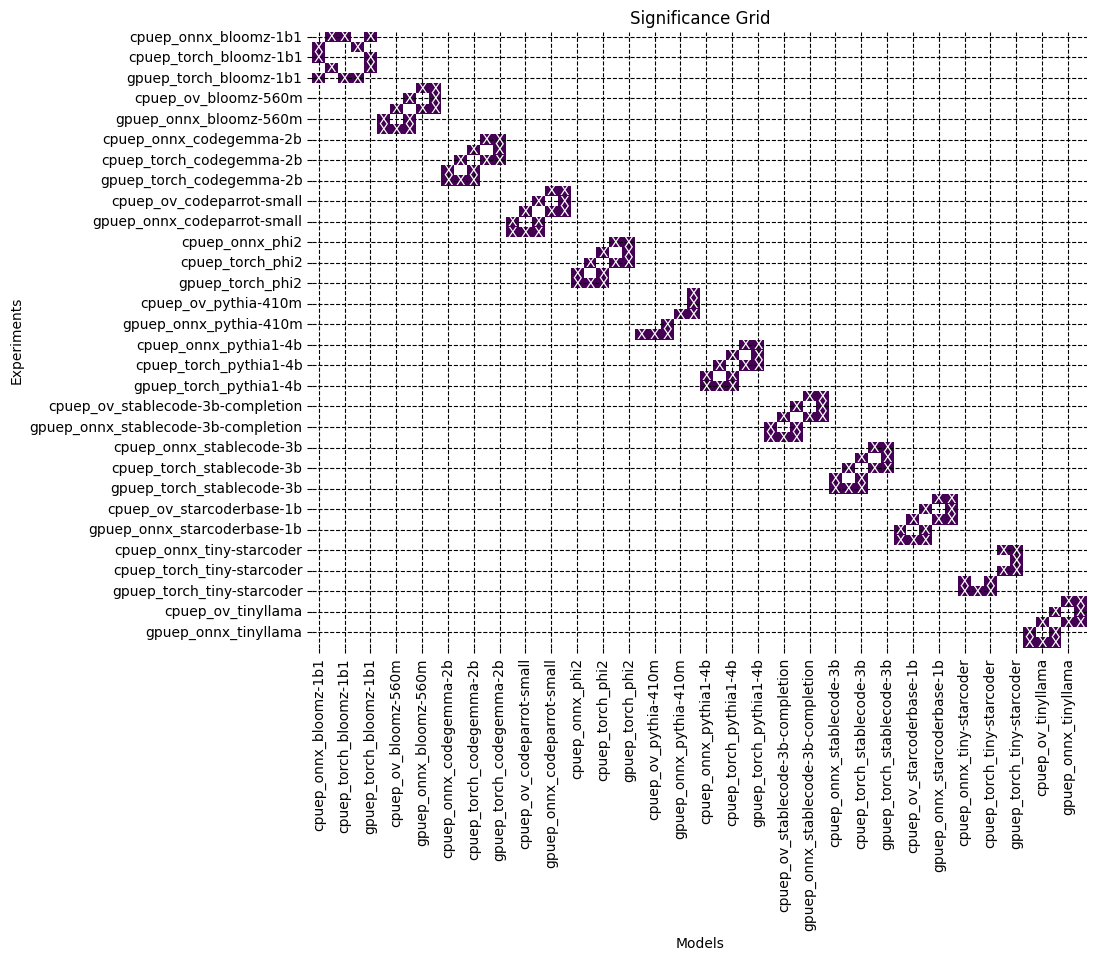

In [39]:
plot_dunn_test_grid(combined_df)

In [40]:
#SAVE_FIGS = False
#plot_dunn_test_grid(cpu_df)

SAVE_FIGS:False


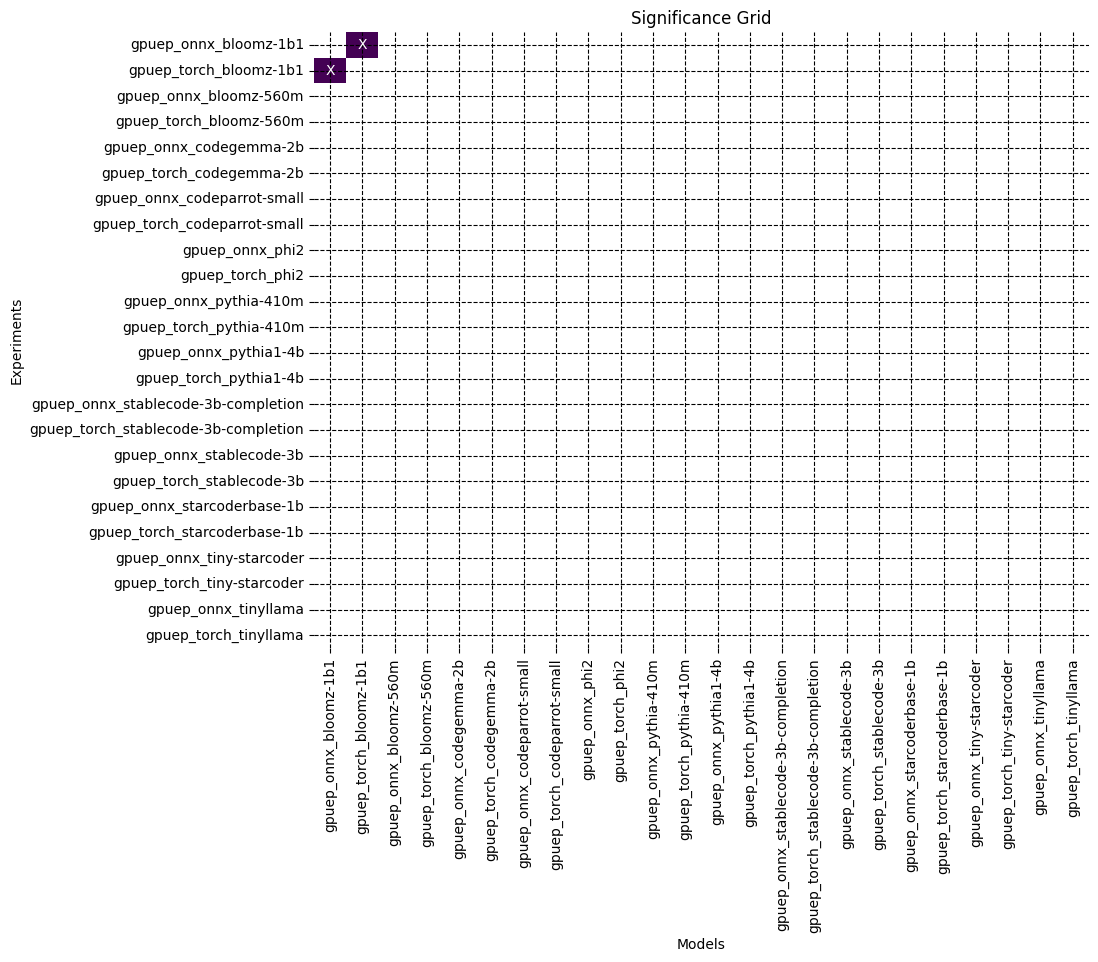

In [41]:
#SAVE_FIGS = False
plot_dunn_test_grid(gpu_df)

## Games-Howell

In [42]:


# Set the directory path where your CSV files are stored
#path = '/path/to/your/csv/files'
all_files = glob.glob(os.path.join(path, "gameshowell_*.csv"))

df_list = []
for file in all_files:
    df = pd.read_csv(file, header=0)  # Assumes the first row is the header
    df.set_index(df.columns[0], inplace=True)  # Set the first column as the index
    df_list.append(df)

combined_df = pd.concat(df_list, axis=0)


combined_df

,cpuep_ov_bloomz-1b1,cpuep_torch_bloomz-1b1,gpuep_onnx_bloomz-1b1,gpuep_torch_bloomz-1b1,cpuep_ov_bloomz-560m,cpuep_torch_bloomz-560m,gpuep_onnx_bloomz-560m,gpuep_torch_bloomz-560m,cpuep_ov_codegemma-2b,cpuep_torch_codegemma-2b,...,gpuep_onnx_starcoderbase-1b,gpuep_torch_starcoderbase-1b,cpuep_ov_tiny-starcoder,cpuep_torch_tiny-starcoder,gpuep_onnx_tiny-starcoder,gpuep_torch_tiny-starcoder,cpuep_ov_tinyllama,cpuep_torch_tinyllama,gpuep_onnx_tinyllama,gpuep_torch_tinyllama
A,,,,,,,,,,,,,,,,,,,,,
cpuep_onnx_bloomz-1b1,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_ov_bloomz-1b1,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_torch_bloomz-1b1,NaN,NaN,X,X,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gpuep_onnx_bloomz-1b1,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_onnx_bloomz-560m,NaN,NaN,NaN,NaN,X,NaN,X,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_ov_bloomz-560m,NaN,NaN,NaN,NaN,NaN,X,X,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_torch_bloomz-560m,NaN,NaN,NaN,NaN,NaN,NaN,X,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gpuep_onnx_bloomz-560m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpuep_onnx_codegemma-2b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
def plot_gameshowell_test_grid(df):
    # https://how2matplotlib.com/heatmap-in-matplotlib.html
    # Assuming 'X' marks significance and the DataFrame is formatted with models as columns and rows
    # Convert 'X' to numerical values for plotting (1 for 'X', 0 for '')
    
    try:
        plot_data = df.replace({'X': 1, '': 0})
    except:
        print("check X or True")
    
    annotations = plot_data.applymap(lambda x: 'X' if x == 1 else '')
    
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    #sns.heatmap(plot_data, annot=annotations, cmap="viridis", cbar=False, fmt='g')
    sns.heatmap(plot_data, annot=annotations, cmap="viridis", cbar=False, fmt='') # RdYlBu
    plt.title('Significance Grid')
    plt.xlabel('Models')
    plt.ylabel('Experiments')
    
    plt.grid(visible=True, color='black', linestyle='--')
    plt.savefig(joined_dir+f"/gameshowell_{dependent_variable}_merged.png") if SAVE_FIGS else print(f"SAVE_FIGS:{SAVE_FIGS}")
    plt.show()


SAVE_FIGS:False


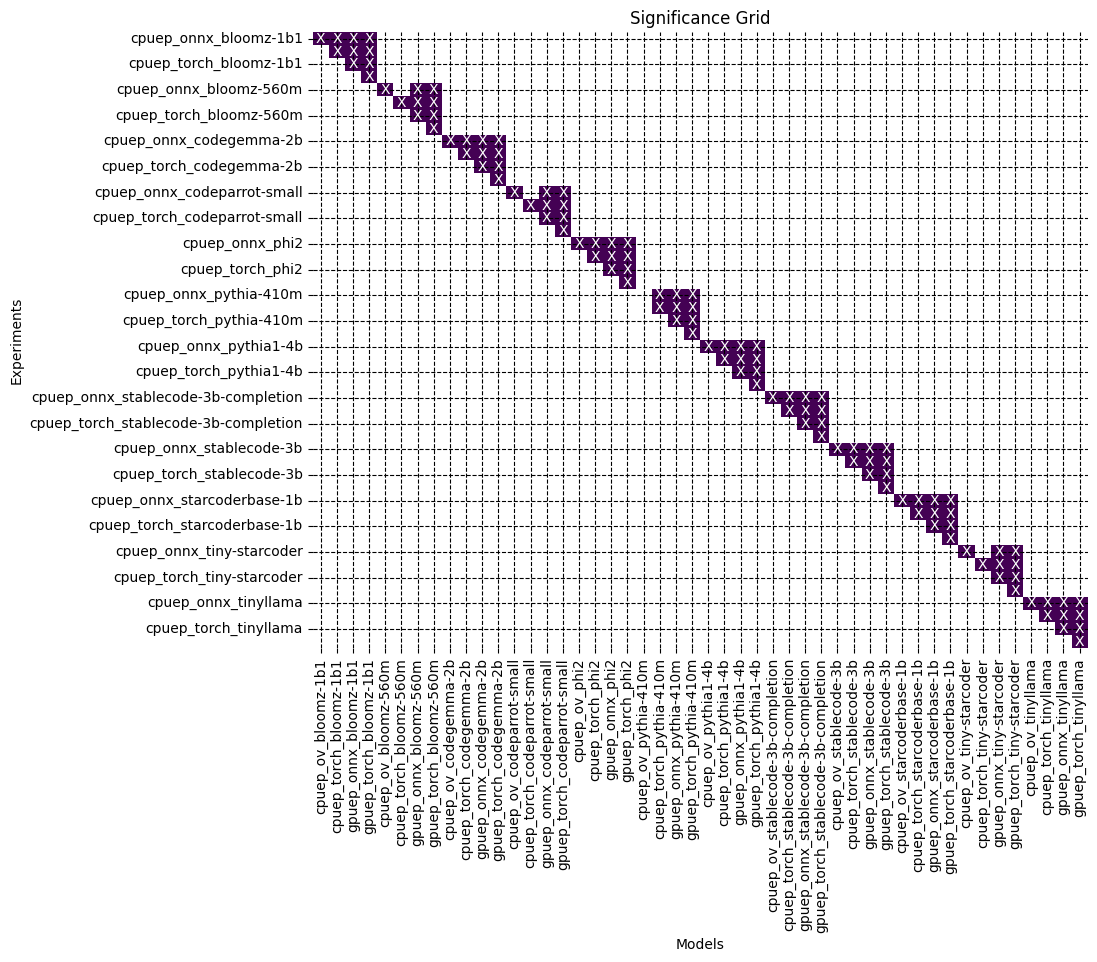

In [44]:
plot_gameshowell_test_grid(combined_df)

## postprocessing of latex files, 
run after running all above

In [121]:
## first run all above for all dependent variables

SAVE_TABLES= False # # change
SAVE_FIGS = False

In [122]:
joined_dir

'D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cudaep_02/avg_used_memory_pct_mib/joined'

In [123]:
general_path

'D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cudaep_02/'

In [124]:
variables

['global_energy',
 'avg_cpu_usage_config',
 'avg_used_memory_pct_config',
 'duration']

In [125]:
cuda_variables

['avg_utilization_gpu_config',
 'avg_utilization_memory_config',
 'avg_used_memory_pct_mib']

In [126]:
import os


def replace_underscores(directory):
    # Loop through all files in the specified directory
    for filename in os.listdir(directory):
        if filename.endswith('.tex'):  # Process only LaTeX files
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                content = file.read()

            # Replace underscores with spaces
            updated_content = content.replace('_', ' ')

            # Write the updated content back to the file
            if SAVE_TABLES:
                with open(filepath, 'w', encoding='utf-8') as file:
                    file.write(updated_content) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
                print(f"Updated {filename}")

# Example usage
if __name__ == "__main__":

    
    #dependent_variable= variables[0]
    for dependent_variable in cuda_variables: #CHANGE if cuda_variables, or variables
        #path = f"D:/GAISSA/energy-repo/last_repo/results_tests_02/{dependent_variable}" 
        path = general_path + dependent_variable
        
        directory = path + "/joined/"  # Specify the directory containing your LaTeX files
        print(directory)
        replace_underscores(directory) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
#path = f"D:/GAISSA/energy-repo/last_repo/results_tests/{dependent_variable}" 

D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cudaep_02/avg_utilization_gpu_config/joined/
Updated kruskal_avg_utilization_gpu_config_merged.tex
Updated levene_avg_utilization_gpu_config_merged.tex
Updated normality_avg_utilization_gpu_config_merged.tex
Updated welch_avg_utilization_gpu_config_merged.tex
D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cudaep_02/avg_utilization_memory_config/joined/
Updated kruskal_avg_utilization_memory_config_merged.tex
Updated levene_avg_utilization_memory_config_merged.tex
Updated normality_avg_utilization_memory_config_merged.tex
Updated welch_avg_utilization_memory_config_merged.tex
D:/GAISSA/energy-repo/repo_sept_last_update/statistical_results_nov_cudaep_02/avg_used_memory_pct_mib/joined/
Updated kruskal_avg_used_memory_pct_mib_merged.tex
Updated levene_avg_used_memory_pct_mib_merged.tex
Updated normality_avg_used_memory_pct_mib_merged.tex
Updated welch_avg_used_memory_pct_mib_merged.tex
